<a href="https://colab.research.google.com/github/Azieyy/Azieyy/blob/main/assignment/ass3/bdm/KicapSambal/ass3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Exploratory Data Analysis (EDA) Using Big Data**

**TEAM MEMBERS:**
```
ZUHAYR ARIF BIN ZAKARIA (MCS231002)
MOHD NOR BIN MOHIDIN (MCS231008)
NABILA HUSNA BINTI ROSLI (MCS231009)
NUR AZIMAH BINTI MOHD SALLEH (MCS231011)
```

**Notes:**
```
This dataset can be explored using Pandas. However, for the sake of the requirement of this assignment,
we are using PySpark to do a summary of the statistic for numerical data.
```

# **Installation and import**

In [1]:
!pip install kaggle
!pip install pyspark
!pip install plotly

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d mohamedbakhet/amazon-books-reviews
!unzip /content/amazon-books-reviews.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
amazon-books-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/amazon-books-reviews.zip
replace Books_rating.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Books_rating.csv        
  inflating: books_data.csv          


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import plotly.express as px

# **Data Wrangling**

In [4]:
# Reading Data
books = pd.read_csv('/content/books_data.csv')
rating = pd.read_csv('/content/Books_rating.csv')

In [5]:
books.shape

(212404, 10)

In [6]:
rating.shape

(3000000, 10)

In [7]:
# Merging both the dataset
df = pd.merge(books,rating, on = 'Title')
df.shape
# Extract only the year
df['publishedDate'] = df['publishedDate'].str.extract(r'(\d{4})')

In [8]:
#extracting usefull columns for our analysis
df = df[['Title','review/score','publisher','authors','categories','ratingsCount','publishedDate','Price']]
df.isna().sum()

Title                208
review/score           0
publisher         782617
authors           390634
categories        551498
ratingsCount     1360694
publishedDate     356397
Price            2518829
dtype: int64

In [9]:
df['Price'].fillna(0, inplace=True)
df['ratingsCount'].fillna(0, inplace=True)
df['categories'].fillna('Not Specified', inplace=True)
df['publisher'].fillna('Not Recorded', inplace=True)

df.isna().sum()

Title               208
review/score          0
publisher             0
authors          390634
categories            0
ratingsCount          0
publishedDate    356397
Price                 0
dtype: int64

In [10]:
# Dropping Null Values
df.dropna(inplace = True)
df.isna().sum()

Title            0
review/score     0
publisher        0
authors          0
categories       0
ratingsCount     0
publishedDate    0
Price            0
dtype: int64

In [11]:
df.shape

(2587907, 8)

# **Data Static Summary**

**Notes 1 :**
data frame should be change from data frame of Pandas to data frame of PySpark
for us to use data frame of PySpark. However, when we need to do the visualization, we need to change it back to data frame of Pandas. That being
said, converting data frame of PySpark to data frame of Pandas took a long time.
Thus, the summary of statistic that being done using PySpark are done separately from the code here. We only copy paste the steps and result from
the other code to here.

**Notes 2 :**
If you want to run this code, we suggest you to run it in another notebook.

In [ ]:
# Convert Pandas DataFrame to PySpark DataFrame
spark = SparkSession.builder.appName("start").getOrCreate()
spark_data = spark.createDataFrame(df)

In [ ]:
from pyspark.sql.functions import mean, min, max, count

# Display the schema
spark_data.printSchema()

# Display the first few rows of the DataFrame
spark_data.show(5)

root
 |-- Title: string (nullable = true)
 |-- review/score: double (nullable = true)
 |-- publisher: string (nullable = true)
 |-- authors: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- ratingsCount: double (nullable = true)
 |-- publishedDate: string (nullable = true)
 |-- Price: double (nullable = true)

+--------------------+------------+------------+----------------+--------------------+------------+-------------+-----+
|               Title|review/score|   publisher|         authors|          categories|ratingsCount|publishedDate|Price|
+--------------------+------------+------------+----------------+--------------------+------------+-------------+-----+
|Its Only Art If I...|         4.0|Not Recorded|['Julie Strain']|['Comics & Graphi...|         0.0|         1996|  0.0|
|Dr. Seuss: Americ...|         5.0|   A&C Black|  ['Philip Nel']|['Biography & Aut...|         0.0|         2005|  0.0|
|Dr. Seuss: Americ...|         5.0|   A&C Black|  ['Philip Nel']|

In [ ]:
# Use the describe function to get summary statistics
numeric_summary = spark_data.describe()

from pyspark.sql.functions import format_number

# Summary statistics for specific columns
column_names = ['review/score', 'ratingsCount', 'Price']
selected_summary = spark_data.select(column_names).describe()

# Format the summary statistics to show only two decimal places
formatted_summary = selected_summary.select(
    col('summary'),
    format_number(col('review/score').cast('double'), 2).alias('review/score'),
    format_number(col('ratingsCount').cast('double'), 2).alias('ratingsCount'),
    format_number(col('Price').cast('double'), 2).alias('Price')
)

In [ ]:
# Show the calculated summary statistics
print("Summary Statistics:")
formatted_summary.show()

Summary Statistics:
+-------+------------+------------+------------+
|summary|review/score|ratingsCount|       Price|
+-------+------------+------------+------------+
|  count|2,587,907.00|2,587,907.00|2,587,907.00|
|   mean|        4.22|      172.08|        3.38|
| stddev|        1.20|      641.34|       12.84|
|    min|        1.00|        0.00|        0.00|
|    max|        5.00|    4,895.00|      995.00|
+-------+------------+------------+------------+



In [ ]:
# Convert PySpark DataFrame to Pandas DataFrame for easier integration with Matplotlib
dataPd = spark_data.toPandas()

# **Data Visualization**

## **Notes:**
1. This data visualiazation are run without running the code in Data Summary Statistic. Due to it takes a long time to convert dataframe of PySpark to dataframe of Pandas
2. You might encounter error if you run code in Data Summary Statistic

Code below are producing horizontal bar chart for top 20 authors with
the total books that they had write.

In [12]:
categories_stats = df.groupby('authors')['Title'].nunique().sort_values()

fig = px.bar(
    x=categories_stats.values[-20:],
    y=categories_stats.index[-20:],
    orientation='h',
    color=categories_stats.index[-20:]
)

fig.update_layout(
    title={'text': 'Number of Titles per Author (Top 20)', 'font': {'size': 22, 'color': 'blue'}, 'x': 0.5},
    xaxis_title={'text': 'Books Count', 'font': {'size': 16, 'color': 'blue'}},
    yaxis_title={'text': 'Author', 'font': {'size': 16, 'color': 'blue'}}
)

fig.show()

Pie chart below are to show the percentage of genre that had been produced

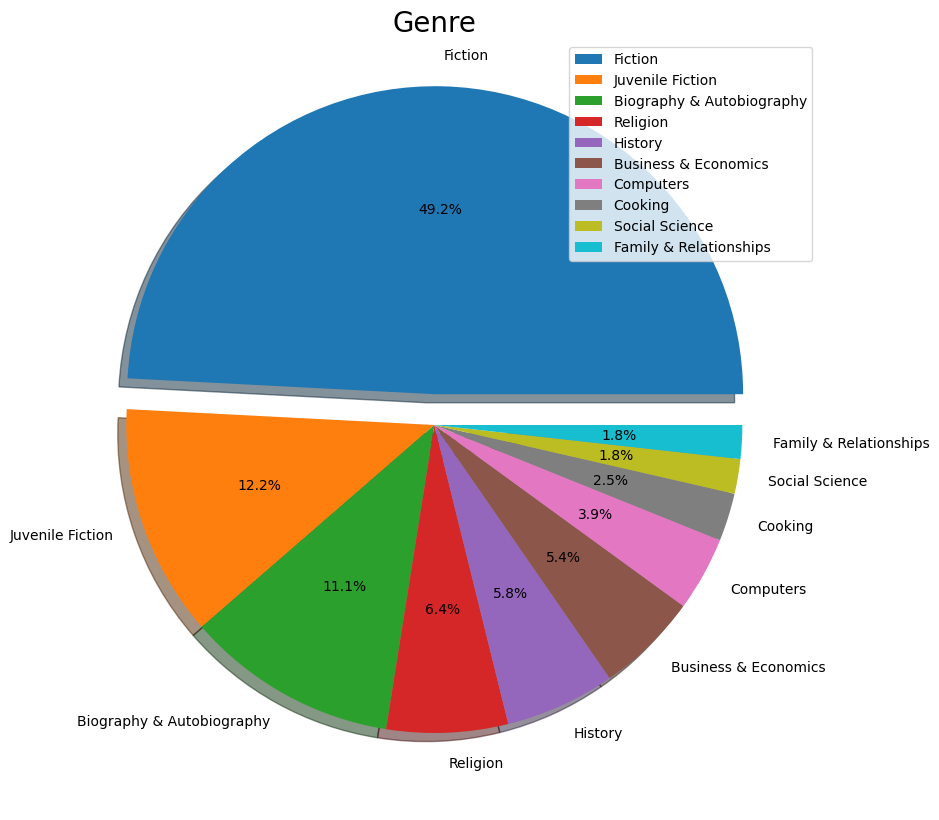

In [13]:
plt.rcParams['figure.figsize'] = (10, 10)
labels=['Fiction','Juvenile Fiction','Biography & Autobiography','Religion','History','Business & Economics','Computers','Cooking','Social Science','Family & Relationships']
plt.pie(df['categories'].value_counts().head(10),explode=(0.1,0,0,0,0,0,0,0,0,0), labels=labels,autopct='%1.1f%%', shadow=True)
plt.title('Genre', fontsize = 20)
plt.axis('off')
plt.legend()
plt.show()

Top 20 books with total numbers of review

In [14]:
ratings_per_book = df.groupby('Title')['ratingsCount'].count().sort_values()

fig = px.bar(x=ratings_per_book.values[-20:], y=ratings_per_book.index[-20:], orientation='h',
             color=ratings_per_book.index[-20:])

fig.update_layout(title={'text': 'Number of Ratings per Book (Top 20)', 'font': {'size': 22, 'color': 'blue'}, 'x': 0.5},
                  xaxis_title={'text': 'Ratings Count', 'font': {'size': 16, 'color': 'blue'}},
                  yaxis_title={'text': 'Book Title', 'font': {'size': 16, 'color': 'blue'}})

fig.show()

Number of genre that received review

In [15]:
ratings_per_book = df.groupby('categories')['Title'].nunique().sort_values()

fig = px.bar(x=ratings_per_book.values[-20:], y=ratings_per_book.index[-20:], orientation='h',
             color=ratings_per_book.index[-20:])

fig.update_layout(title={'text': 'Number of Ratings per Genre (Top 20)', 'font': {'size': 22, 'color': 'blue'}, 'x': 0.5},
                  xaxis_title={'text': 'Ratings Count', 'font': {'size': 16, 'color': 'blue'}},
                  yaxis_title={'text': 'Book Title', 'font': {'size': 16, 'color': 'blue'}})

fig.show()

To show the sales of books by year

In [16]:
total_sales_per_year = df.groupby('publishedDate')['Price'].sum().reset_index()

fig = px.line(
    total_sales_per_year,
    x='publishedDate',
    y='Price',
    title='Total Sales per Year',
    labels={'Price': 'Total Sales'}
)

fig.show()

Top 10 years with the highest sale of books

In [17]:
total_sales_per_year = df.groupby('publishedDate')['Price'].sum().reset_index()

top_10_years = total_sales_per_year.nlargest(10, 'Price')

top_10_years = top_10_years.sort_values(by='Price', ascending=True)

fig = px.bar(
    top_10_years,
    x='Price',
    y='publishedDate',
    orientation='h',
    color='Price',
    title='Top 10 Years with Highest Total Sales (Sorted Ascending)',
    labels={'Price': 'Total Sales'}
)

fig.show()

# **Conclusion**

1. We can easily perform EDA in this dataset using Pandas.
2. If we want to use PySpark, only using it in TB size of data because using it in this dataset, only a waste of storage.
3.